In [65]:
from array import array

import numpy as np
import torch
from sklearn.utils import shuffle

from src.args import Args
from src.networks import VAE
from src.networks.maga_net import MAGANet
from src.registry import setup
from src.common.utils import set_seed
from src.dataset import DspritesDataset, get_dataloaders_2element

import matplotlib.pyplot as plt
# from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import umap
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.decomposition import PCA

import plotly.graph_objects as go

In [66]:
def prepare_model(path_maga, path_vae):
    args1 = Args(file=f"{path_maga}/hyperparameters.yaml")
    args2 = Args(file=f"{path_vae}/hyperparameters.yaml")
    
    if args1.model_name == "maga":
        model_maga = MAGANet(args1)
        model_maga.load_state_dict(torch.load(
            f"{path_maga}/models/model_2element.pth"))
        model_maga = model_maga.to(args1.device)
    
    if args2.model_name == "vae":
        model_vae = VAE(args2)
        model_vae.load_state_dict(torch.load(
            f"{path_vae}/models/model_2element.pth"))
        model_vae = model_vae.to(args2.device)
        
    single_output = False
    test_data = DspritesDataset("../data/2d/test.npz", single_output=single_output)
    _, test_loader = get_dataloaders_2element(
            None, test_data,
            batch_size=args1.batch_size,
            shuffle=False
    )
    return model_maga, model_vae, test_loader, args1, args2

In [67]:
path_maga = "../outputs/run_dev_maga/element_3_300"
path_vae = "../outputs/run_dev_vae/seed_2_250320251556"
model_maga, model_vae, test_loader, args1, args2 = prepare_model(path_maga, path_vae)

In [68]:
batch_idx, (x1, x2) = next(enumerate(test_loader))
print(x1.shape)
x1, x2 = x1.to(args1.device), x2.to(args1.device)  # Move tensors to GPU if available

torch.Size([64, 1, 64, 64])


## Use maga encode, vae decode

In [69]:
# maga model
z, mu1, logvar1, mu2, logvar2, decoded_x1, decoded_x2  = model_maga(x1, x2)  # Forward pass
decoded_x2 = decoded_x2.cpu().detach().squeeze().numpy()

In [70]:
# vae decoder
x = model_vae.decoder_(z)
x = x.cpu().detach().squeeze().numpy()

In [71]:
# vae encoder and decoder
x_vae, mu, logvar = model_vae(x2)
x_vae = x_vae.cpu().detach().squeeze().numpy()

In [72]:
x_gt = x2.cpu().detach().squeeze().numpy()

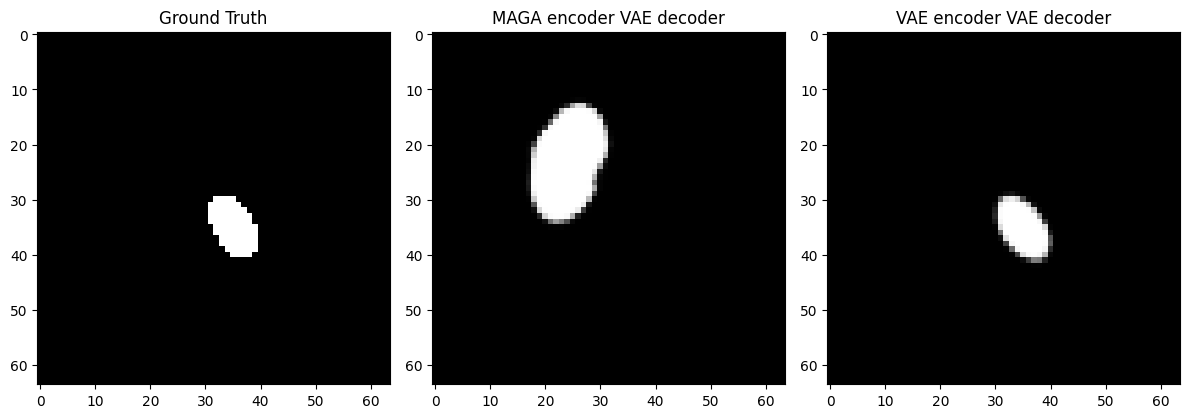

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
axes[0].imshow(x_gt[0],cmap='gray')
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# Second subplot
axes[1].imshow(x[0],cmap='gray')
axes[1].set_title("MAGA encoder VAE decoder")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Third subplot
axes[2].imshow(x_vae[0],cmap='gray')
axes[2].set_title("VAE encoder VAE decoder")
axes[2].set_xlabel("")
axes[2].set_ylabel("")


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## VAE encode, MAGA decode

In [74]:
x1_vae, mu1, logvar1 = model_vae(x1)
z1 = model_vae.reparameterize(mu1, logvar1)
x2_vae, mu2, logvar2 = model_vae(x2)
z2 = model_vae.reparameterize(mu2, logvar2)
z = z2-z1

In [75]:
x_maga = model_maga.decoder_(z,x1)
x_maga = x_maga.cpu().detach().squeeze().numpy()

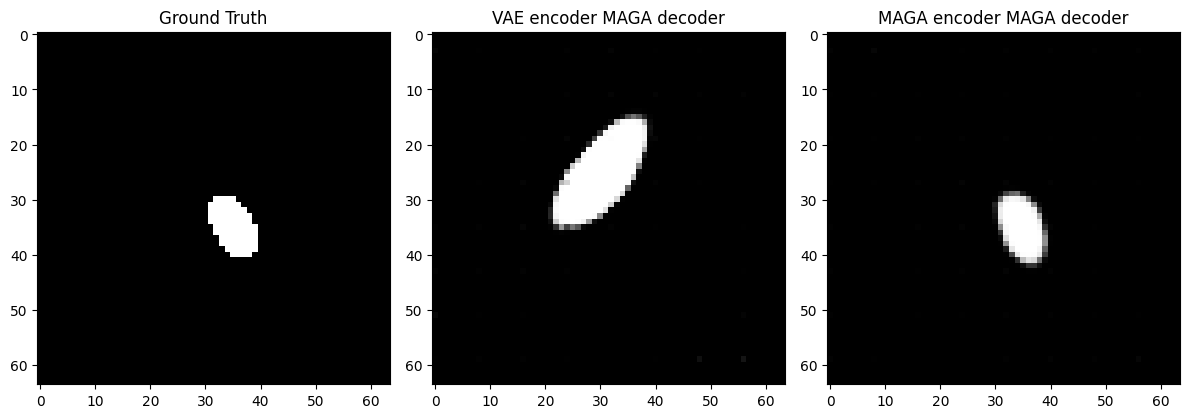

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# First subplot
axes[0].imshow(x_gt[0],cmap='gray')
axes[0].set_title("Ground Truth")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# Second subplot
axes[1].imshow(x_maga[0],cmap='gray')
axes[1].set_title("VAE encoder MAGA decoder")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Third subplot
axes[2].imshow(decoded_x2[0],cmap='gray')
axes[2].set_title("MAGA encoder MAGA decoder")
axes[2].set_xlabel("")
axes[2].set_ylabel("")


# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()